# Neuroevolution (GA) Multi-Seed Training with Best-Model Selection

This notebook trains a Genetic Algorithm across multiple seeds, with:
- **Best genome tracking** per generation (saved as `.npy`)
- **Deterministic evaluation** of best genomes (20 episodes per seed)
- **Comparable metrics** to the DQN & PPO notebook (lab009_v1)

---

In [1]:
import os, sys, random, time
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
import imageio.v2 as imageio
from IPython.display import Image, display

In [2]:
# Add src/ to path so we can import the GA modules
SRC_DIR = os.path.join(os.path.dirname(os.path.abspath("__file__")), "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

from src.evolution.genetic_algorithm import GeneticAlgorithm
from src.evolution.neural_network import NeuralNetwork

In [3]:
# Global Configuration

SEED_LIST = [42, 123, 999]

NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))
GYMNASIUM_MODEL = "LunarLander-v3"

WIND_ENABLED = False

# GA hyperparameters
INPUT_SIZE = 8
HIDDEN1_SIZE = 10
HIDDEN2_SIZE = 10
OUTPUT_SIZE = 4

POPULATION_SIZE = 50
MUTATION_RATE = 0.05
GENERATIONS = 5000
EVAL_SEEDS_PER_GEN = 3  # seeds used to evaluate each genome during training

# Evaluation
EVALUATION_EPISODES = 20

# Parallelization
MAX_WORKERS = 20

print(f"Seeds: {SEED_LIST}")
print(f"Wind enabled: {WIND_ENABLED}")
print(f"Generations: {GENERATIONS}")
print(f"Population size: {POPULATION_SIZE}")
print(f"Mutation rate: {MUTATION_RATE}")
print(f"Eval seeds per generation: {EVAL_SEEDS_PER_GEN}")
print(f"Evaluation episodes per seed: {EVALUATION_EPISODES}")
print(f"Max workers: {MAX_WORKERS}")

Seeds: [42, 123, 999]
Wind enabled: False
Generations: 5000
Population size: 50
Mutation rate: 0.05
Eval seeds per generation: 3
Evaluation episodes per seed: 20
Max workers: 20


In [4]:
print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)

Python: 3.12.3
NumPy: 2.4.2


In [5]:
# Environment inspection
env_tmp = gym.make(GYMNASIUM_MODEL)

print("Observation space:", env_tmp.observation_space)
print("Action space:", env_tmp.action_space)

obs, info = env_tmp.reset()
print("Initial observation:", obs)

env_tmp.close()

Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)
Initial observation: [-0.0022769   1.4000747  -0.2306374  -0.4820201   0.00264511  0.05224282
  0.          0.        ]


In [6]:
def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)


def evaluate_genome_deterministic(genome, n_episodes, seed=None):
    """
    Evaluate a genome deterministically over n_episodes.
    No early termination. Returns list of per-episode rewards.
    """
    nn = NeuralNetwork(INPUT_SIZE, HIDDEN1_SIZE, HIDDEN2_SIZE, OUTPUT_SIZE, genome)
    env = gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED)
    rewards = []

    for ep in range(n_episodes):
        ep_seed = seed + ep if seed is not None else None
        obs, _ = env.reset(seed=ep_seed)
        total_reward = 0.0
        done = False

        while not done:
            output = nn.forward(obs)
            action = np.argmax(output)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += float(reward)

        rewards.append(total_reward)

    env.close()
    return rewards


def record_genome_gif(genome, seed, output_path):
    """
    Record a single episode GIF of a genome.
    """
    nn = NeuralNetwork(INPUT_SIZE, HIDDEN1_SIZE, HIDDEN2_SIZE, OUTPUT_SIZE, genome)
    env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
    obs, _ = env.reset(seed=seed)
    frames = []
    done = False

    while not done:
        frames.append(env.render())
        output = nn.forward(obs)
        action = np.argmax(output)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    env.close()
    imageio.mimsave(output_path, frames, fps=30, loop=0)
    return output_path

In [ ]:
# Training loop: GA x seeds

from IPython.display import display as ipy_display

training_results = {}   # {seed: {"best": [], "avg": [], "worst": []}}
training_times = {}     # {seed: seconds}
best_genomes = {}       # {seed: genome}
best_genome_paths = {}  # {seed: path}
total_env_steps = {}    # {seed: int}

CHART_UPDATE_FREQ = 100

for seed in SEED_LIST:
    print(f"\n{'='*60}")
    print(f"GA | Seed {seed}")
    print(f"{'='*60}\n")

    # Create timestamped run directory
    run_timestamp = datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
    run_dir = os.path.join(NOTEBOOK_DIR, "models", "ga", run_timestamp)
    os.makedirs(run_dir, exist_ok=True)

    set_all_seeds(seed)

    ga = GeneticAlgorithm(
        INPUT_SIZE, 
        HIDDEN1_SIZE, 
        HIDDEN2_SIZE, 
        OUTPUT_SIZE,
        POPULATION_SIZE, 
        MUTATION_RATE, 
        render=False, 
        max_workers=MAX_WORKERS,
        generations=GENERATIONS
    )

    best_fitness_history = []
    avg_fitness_history = []
    worst_fitness_history = []
    overall_best_fitness = -np.inf
    overall_best_genome = np.array([])
    env_steps = 0

    plot_handle = None
    stats_handle = None

    t_start = time.time()

    for gen in range(GENERATIONS):
        sorted_population = ga.evaluate_population(gen)
        fitness_values = [fitness for _, fitness in sorted_population]
        best_fitness = fitness_values[0]
        worst_fitness = fitness_values[-1]
        avg_fitness = sum(fitness_values) / len(fitness_values)

        best_fitness_history.append(best_fitness)
        avg_fitness_history.append(avg_fitness)
        worst_fitness_history.append(worst_fitness)

        # Track best genome across all generations
        if best_fitness > overall_best_fitness:
            overall_best_fitness = best_fitness
            overall_best_genome = sorted_population[0][0].copy()

        env_steps += POPULATION_SIZE * EVAL_SEEDS_PER_GEN * 300

        if (gen + 1) % CHART_UPDATE_FREQ == 0:
            # Update stats text
            recent_avg = np.mean(avg_fitness_history[-100:])
            recent_best = np.mean(best_fitness_history[-100:])
            stats_text = (
                f"Generation {gen + 1} | "
                f"Best: {best_fitness:>8.2f} | "
                f"Avg: {avg_fitness:>8.2f} | "
                f"Worst: {worst_fitness:>8.2f} | "
                f"Overall Best: {overall_best_fitness:>8.2f} | "
                f"Recent Avg(100): {recent_avg:.1f} | "
                f"MR: {ga.mutation_rate:.4f}"
            )
            if stats_handle is None:
                stats_handle = ipy_display(stats_text, display_id=True)
            else:
                stats_handle.update(stats_text)

            # Update plot
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

            ax1.plot(best_fitness_history, alpha=0.3, color='blue')
            ax1.plot(avg_fitness_history, alpha=0.3, color='orange')
            window = min(50, len(best_fitness_history))
            rolling_best = pd.Series(best_fitness_history).rolling(window).mean()
            rolling_avg = pd.Series(avg_fitness_history).rolling(window).mean()
            ax1.plot(rolling_best, color='blue', linewidth=2, label='Best (rolling)')
            ax1.plot(rolling_avg, color='orange', linewidth=2, label='Avg (rolling)')
            ax1.axhline(y=200, color='red', linestyle='--', alpha=0.5)
            ax1.set_title(f"Fitness - Gen {gen + 1}")
            ax1.set_xlabel("Generation")
            ax1.set_ylabel("Fitness")
            ax1.legend(fontsize=8)
            ax1.grid(True, alpha=0.3)

            success = np.array(best_fitness_history) >= 200
            rolling_success = pd.Series(success.astype(float)).rolling(window).mean() * 100
            ax2.plot(rolling_success, color='green', linewidth=2)
            ax2.axhline(y=100, color='green', linestyle=':', alpha=0.4)
            ax2.set_title(f"Success Rate (best >= 200)")
            ax2.set_xlabel("Generation")
            ax2.set_ylabel("Success Rate (%)")
            ax2.set_ylim(-5, 105)
            ax2.grid(True, alpha=0.3)

            plt.tight_layout()

            if plot_handle is None:
                plot_handle = ipy_display(fig, display_id=True)
            else:
                plot_handle.update(fig)
            plt.close(fig)

        ga.next_generation(sorted_population)

    t_elapsed = time.time() - t_start

    # Save best genome
    genome_path = os.path.join(run_dir, f"best_genome_seed{seed}.npy")
    np.save(genome_path, overall_best_genome)

    # Save fitness history
    history_path = os.path.join(run_dir, f"fitness_history_seed{seed}.npz")
    np.savez(history_path,
             best=best_fitness_history,
             avg=avg_fitness_history,
             worst=worst_fitness_history)

    training_results[seed] = {
        "best": best_fitness_history,
        "avg": avg_fitness_history,
        "worst": worst_fitness_history,
    }
    training_times[seed] = t_elapsed
    best_genomes[seed] = overall_best_genome
    best_genome_paths[seed] = genome_path
    total_env_steps[seed] = env_steps

    print(f"\nTraining time: {t_elapsed/60:.1f} min ({t_elapsed:.0f} s)")
    print(f"Overall best fitness: {overall_best_fitness:.2f}")
    print(f"Best genome saved: {genome_path}")
    print(f"Estimated env steps: {env_steps:,}")

print(f"\nGA: All {len(SEED_LIST)} seeds trained.")

# Training Summary Table
print(f"\n{'='*60}")
print("TRAINING SUMMARY (all seeds)")
print(f"{'='*60}\n")

rows = []
for seed in SEED_LIST:
    rows.append({
        "Seed": seed,
        "Best Fitness": f"{max(training_results[seed]['best']):.2f}",
        "Final Avg": f"{np.mean(training_results[seed]['avg'][-100:]):.2f}",
        "Time (min)": f"{training_times[seed]/60:.1f}",
        "Est. Env Steps": f"{total_env_steps[seed]:,}",
    })

print(pd.DataFrame(rows).to_string(index=False))


GA | Seed 42

Generation   100 | Best:   144.97 | Avg:   -15.92 | Worst:  -229.74 | Overall Best:   268.19
Generation   200 | Best:   169.76 | Avg:    92.38 | Worst:  -129.27 | Overall Best:   291.34
Generation   300 | Best:   275.50 | Avg:   225.47 | Worst:    68.37 | Overall Best:   301.76
Generation   400 | Best:   302.57 | Avg:   237.90 | Worst:    47.63 | Overall Best:   314.45
Generation   500 | Best:   271.02 | Avg:   222.70 | Worst:    42.47 | Overall Best:   314.45
Generation   600 | Best:   269.94 | Avg:   225.06 | Worst:    34.19 | Overall Best:   316.52
Generation   700 | Best:   298.43 | Avg:   204.78 | Worst:     8.65 | Overall Best:   325.59
Generation   800 | Best:   280.09 | Avg:   190.03 | Worst:    23.60 | Overall Best:   325.59
Generation   900 | Best:   287.16 | Avg:   202.97 | Worst:   -91.87 | Overall Best:   325.59
Generation  1000 | Best:   287.88 | Avg:   169.43 | Worst:    -6.34 | Overall Best:   325.59
Generation  1100 | Best:   306.92 | Avg:   265.08 | Wor

In [8]:
# Training Time Summary

rows = []
for seed in SEED_LIST:
    t = training_times[seed]
    rows.append({
        "Algorithm": "GA",
        "Seed": seed,
        "Time (s)": f"{t:.0f}",
        "Time (min)": f"{t/60:.1f}",
    })

times = list(training_times.values())
rows.append({
    "Algorithm": "GA",
    "Seed": "Mean",
    "Time (s)": f"{np.mean(times):.0f}",
    "Time (min)": f"{np.mean(times)/60:.1f}",
})

print("*** TRAINING TIME SUMMARY ***")
print(f"Generations: {GENERATIONS} | Population: {POPULATION_SIZE} | Workers: {MAX_WORKERS}")
print()
print(pd.DataFrame(rows).to_string(index=False))

*** TRAINING TIME SUMMARY ***
Generations: 5000 | Population: 50 | Workers: 20

Algorithm Seed Time (s) Time (min)
       GA   42     1012       16.9
       GA  123      979       16.3
       GA  999      989       16.5
       GA Mean      993       16.6


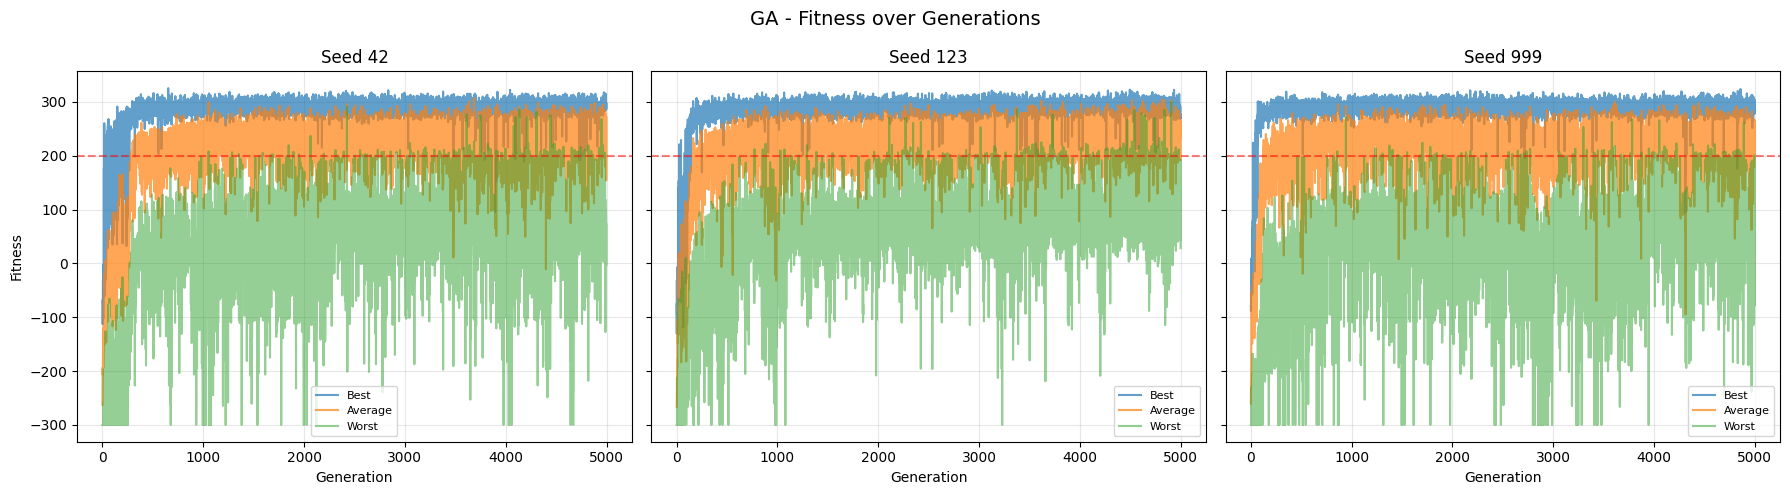

In [9]:
# Per-Seed: Fitness over Generations

fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
if len(SEED_LIST) == 1:
    axes = [axes]

for ax, seed in zip(axes, SEED_LIST):
    ax.plot(training_results[seed]["best"], alpha=0.7, label="Best")
    ax.plot(training_results[seed]["avg"], alpha=0.7, label="Average")
    ax.plot(training_results[seed]["worst"], alpha=0.5, label="Worst")
    ax.axhline(y=200, color='red', linestyle='--', alpha=0.5)
    ax.set_title(f"Seed {seed}")
    ax.set_xlabel("Generation")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

axes[0].set_ylabel("Fitness")
fig.suptitle("GA - Fitness over Generations", fontsize=14)
plt.tight_layout()
plt.show()

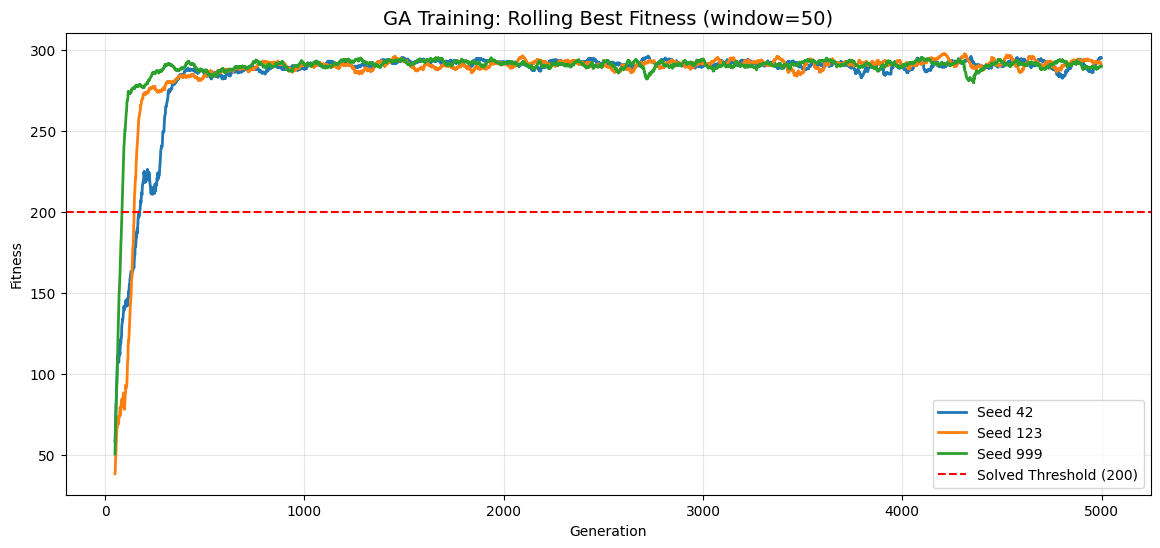

In [10]:
# Aggregated: Rolling Best Fitness Overlay (all seeds on one chart)

seed_colors = list(plt.colormaps["tab10"](range(10)))

plt.figure(figsize=(14, 6))
for i, seed in enumerate(SEED_LIST):
    rolling = pd.Series(training_results[seed]["best"]).rolling(50).mean()
    plt.plot(rolling, color=seed_colors[i], linewidth=2, label=f"Seed {seed}")

plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.title("GA Training: Rolling Best Fitness (window=50)", fontsize=14)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

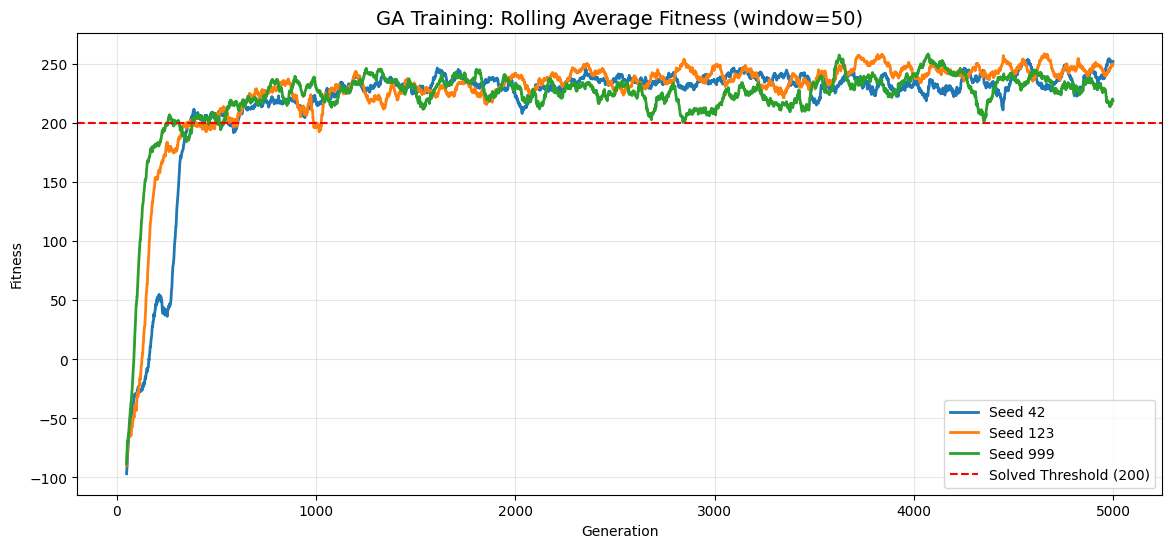

In [11]:
# Aggregated: Rolling Average Fitness Overlay (all seeds on one chart)

plt.figure(figsize=(14, 6))
for i, seed in enumerate(SEED_LIST):
    rolling = pd.Series(training_results[seed]["avg"]).rolling(50).mean()
    plt.plot(rolling, color=seed_colors[i], linewidth=2, label=f"Seed {seed}")

plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.title("GA Training: Rolling Average Fitness (window=50)", fontsize=14)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

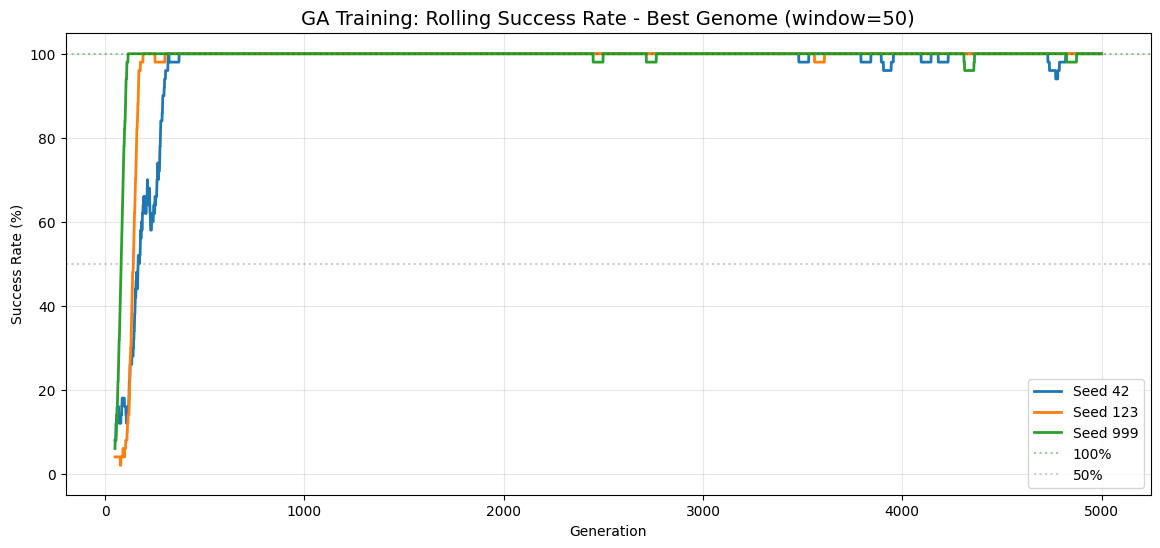

In [12]:
# Rolling Success Rate over Training (best fitness >= 200)

plt.figure(figsize=(14, 6))
for i, seed in enumerate(SEED_LIST):
    success = np.array(training_results[seed]["best"]) >= 200
    rolling_success = pd.Series(success.astype(float)).rolling(50).mean() * 100
    plt.plot(rolling_success, color=seed_colors[i], linewidth=2, label=f"Seed {seed}")

plt.axhline(y=100, color='green', linestyle=':', alpha=0.4, label='100%')
plt.axhline(y=50, color='gray', linestyle=':', alpha=0.4, label='50%')
plt.title("GA Training: Rolling Success Rate - Best Genome (window=50)", fontsize=14)
plt.xlabel("Generation")
plt.ylabel("Success Rate (%)")
plt.ylim(-5, 105)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
# Evaluation: deterministic episodes per seed (best genome)

evaluation_results = {}  # {seed: np.array}

for seed in SEED_LIST:
    print(f"Evaluating GA seed {seed} (best genome)...")

    set_all_seeds(seed)
    genome = best_genomes[seed]

    rewards = evaluate_genome_deterministic(genome, EVALUATION_EPISODES, seed=seed)
    evaluation_results[seed] = np.array(rewards)

    mean_r = np.mean(rewards)
    std_r = np.std(rewards)
    success = np.sum(np.array(rewards) >= 200) / len(rewards) * 100
    print(f"  Reward: {mean_r:.2f} +/- {std_r:.2f} | Success: {success:.0f}%")

print(f"\nEvaluation complete for all seeds.")

Evaluating GA seed 42 (best genome)...
  Reward: 242.97 +/- 82.13 | Success: 85%
Evaluating GA seed 123 (best genome)...
  Reward: 211.47 +/- 124.49 | Success: 65%
Evaluating GA seed 999 (best genome)...
  Reward: 277.70 +/- 34.51 | Success: 95%

Evaluation complete for all seeds.


In [14]:
# Evaluation Summary Table

rows = []
for seed in SEED_LIST:
    r = evaluation_results[seed]
    rows.append({
        "Seed": seed,
        "Mean Reward": f"{np.mean(r):.2f}",
        "Std Dev": f"{np.std(r):.2f}",
        "Min Reward": f"{np.min(r):.2f}",
        "Max Reward": f"{np.max(r):.2f}",
        "Success Rate": f"{(r >= 200).sum() / len(r) * 100:.1f}%"
    })

all_r = np.concatenate([evaluation_results[s] for s in SEED_LIST])
rows.append({
    "Seed": "Overall",
    "Mean Reward": f"{np.mean(all_r):.2f}",
    "Std Dev": f"{np.std(all_r):.2f}",
    "Min Reward": f"{np.min(all_r):.2f}",
    "Max Reward": f"{np.max(all_r):.2f}",
    "Success Rate": f"{(all_r >= 200).sum() / len(all_r) * 100:.1f}%"
})

print(f"*** GA MULTI-SEED EVALUATION SUMMARY ***")
print(f"Episodes per seed: {EVALUATION_EPISODES} | Total: {len(all_r)}")
print(pd.DataFrame(rows).to_string(index=False))

*** GA MULTI-SEED EVALUATION SUMMARY ***
Episodes per seed: 20 | Total: 60
   Seed Mean Reward Std Dev Min Reward Max Reward Success Rate
     42      242.97   82.13      30.79     314.42        85.0%
    123      211.47  124.49     -25.34     317.55        65.0%
    999      277.70   34.51     153.02     326.53        95.0%
Overall      244.05   92.43     -25.34     326.53        81.7%


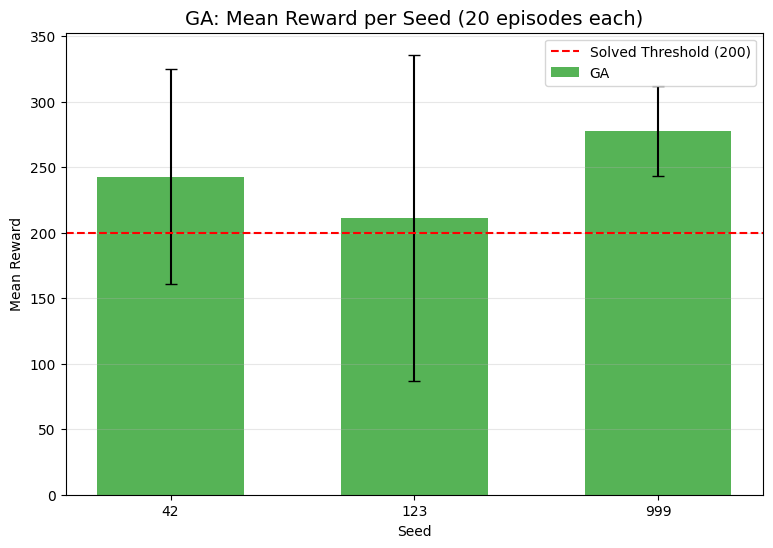

In [15]:
# Evaluation Bar Chart

n_seeds = len(SEED_LIST)
x = np.arange(n_seeds)

means = [np.mean(evaluation_results[s]) for s in SEED_LIST]
stds = [np.std(evaluation_results[s]) for s in SEED_LIST]

plt.figure(figsize=(max(8, 3 * n_seeds), 6))
plt.bar(x, means, 0.6, yerr=stds, capsize=4, label='GA', alpha=0.8, color='tab:green')
plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.xticks(x, [str(s) for s in SEED_LIST])
plt.title(f"GA: Mean Reward per Seed ({EVALUATION_EPISODES} episodes each)", fontsize=14)
plt.xlabel("Seed")
plt.ylabel("Mean Reward")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

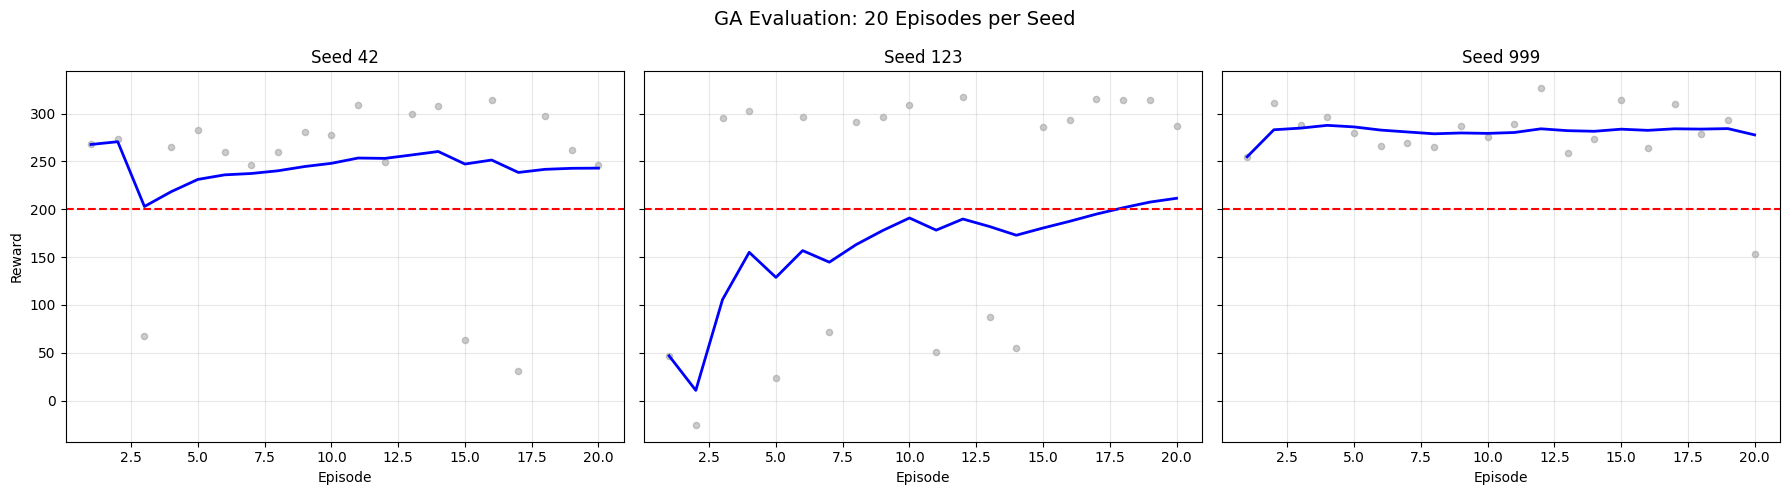

In [16]:
# Evaluation Convergence Plots (per seed)

fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
if len(SEED_LIST) == 1:
    axes = [axes]

for ax, seed in zip(axes, SEED_LIST):
    rewards = evaluation_results[seed]
    episodes = np.arange(1, len(rewards) + 1)
    running_mean = np.cumsum(rewards) / episodes

    ax.scatter(episodes, rewards, color='gray', alpha=0.4, s=20)
    ax.plot(episodes, running_mean, color='blue', linewidth=2)
    ax.axhline(y=200, color='red', linestyle='--')
    ax.set_title(f"Seed {seed}")
    ax.set_xlabel("Episode")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Reward")
fig.suptitle(f"GA Evaluation: {EVALUATION_EPISODES} Episodes per Seed", fontsize=14)
plt.tight_layout()
plt.show()

Generating GIF for GA seed 42 (best genome)...
  Saved: /home/logus/env/iscte/taap_p2/genetic/outputs_ga/ga_seed42.gif


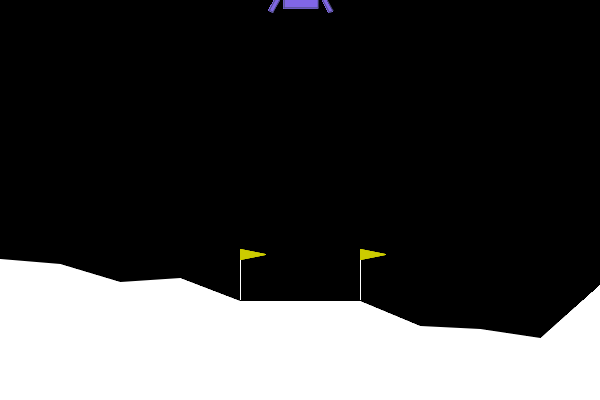

Generating GIF for GA seed 123 (best genome)...
  Saved: /home/logus/env/iscte/taap_p2/genetic/outputs_ga/ga_seed123.gif


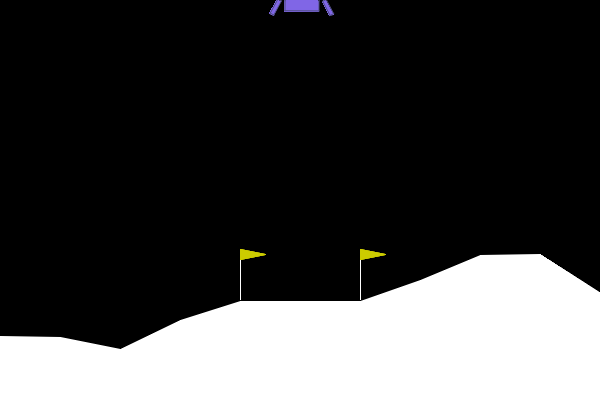

Generating GIF for GA seed 999 (best genome)...
  Saved: /home/logus/env/iscte/taap_p2/genetic/outputs_ga/ga_seed999.gif


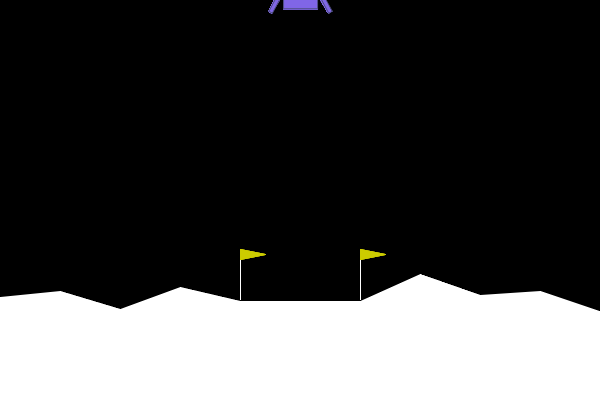

In [17]:
# GIF Visualization (one per seed, best genome)

output_dir = os.path.join(NOTEBOOK_DIR, "outputs_ga")
os.makedirs(output_dir, exist_ok=True)

for seed in SEED_LIST:
    print(f"Generating GIF for GA seed {seed} (best genome)...")

    gif_path = os.path.join(output_dir, f"ga_seed{seed}.gif")
    record_genome_gif(best_genomes[seed], seed, gif_path)

    print(f"  Saved: {gif_path}")
    display(Image(filename=gif_path))

In [18]:
# Hyperparameter Table

params = {
    "input_size": INPUT_SIZE,
    "hidden1_size": HIDDEN1_SIZE,
    "hidden2_size": HIDDEN2_SIZE,
    "output_size": OUTPUT_SIZE,
    "population_size": POPULATION_SIZE,
    "mutation_rate": MUTATION_RATE,
    "generations": GENERATIONS,
    "eval_seeds_per_generation": EVAL_SEEDS_PER_GEN,
    "elitism": 3,
    "parent_selection": "top 20%",
    "crossover": "uniform gene-wise",
    "mutation": "Gaussian (clipped +/-0.1)",
    "activation": "tanh (hidden), linear (output)",
    "max_workers": MAX_WORKERS,
}

rows = [{"Parameter": k, "Value": str(v)} for k, v in params.items()]

print("*** GA Hyperparameters ***")
print(pd.DataFrame(rows).to_string(index=False))

*** GA Hyperparameters ***
                Parameter                          Value
               input_size                              8
             hidden1_size                             10
             hidden2_size                             10
              output_size                              4
          population_size                             50
            mutation_rate                           0.05
              generations                           5000
eval_seeds_per_generation                              3
                  elitism                              3
         parent_selection                        top 20%
                crossover              uniform gene-wise
                 mutation      Gaussian (clipped +/-0.1)
               activation tanh (hidden), linear (output)
              max_workers                             20
